In [1]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Resize, Compose

from tqdm import tqdm

import matplotlib.pyplot as plt

In [40]:
mps_avail = torch.backends.mps.is_available()
device = torch.device("mps" if mps_avail else "cpu")
if torch.cuda.is_available(): device = torch.device("cuda")
device

device(type='mps')

In [30]:
class Inception(nn.Module):
    # output channels 
    def __init__(self, in_channels: int, bc1: int, bc2: [], bc3: [], bc4: int):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc1, kernel_size=1),
            nn.ReLU()
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc2[0], out_channels=bc2[1], kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc3[0], out_channels=bc3[1], kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=bc4, kernel_size=1)
        )

    def forward(self, x):
        return torch.concat(
            (self.b1(x), self.b2(x), self.b3(x), self.b4(x)),
            dim=1
        )
     
sample = torch.rand((1,1,28,28))
model = Inception(1, 6, [3, 6], [4, 6], 6)
print(sample.shape, "--->", model(sample).shape)

torch.Size([1, 1, 28, 28]) ---> torch.Size([1, 24, 28, 28])


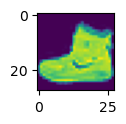

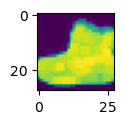

In [3]:
x = FashionMNIST(root="../datasets/", train=True, transform=ToTensor()).data[0].unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float)
plt.figure(figsize=(1,1))
plt.imshow(x.squeeze())
plt.figure(figsize=(1,1))
plt.imshow(F.max_pool2d(input=x, kernel_size=3, stride=1, padding=1).squeeze())

In [34]:
class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1),
            nn.ReLU(),
            
            Inception(3, 16, [8, 16], [8, 16], 16),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14

            Inception(16*4, 8, [12, 8], [12, 8], 8),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7

            Inception(8*4, 4, [6, 4], [6, 4], 4),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # 3,3
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=4*4, out_features=10)
        )
    def forward(self, x):
        return self.layer_stack(x)

model = MiniGoogLeNet()
model = model.to(device)

In [5]:
BS = 32

train_dataloader = DataLoader(
    FashionMNIST(root="../datasets/", train=True, transform=ToTensor()),
    batch_size=BS, shuffle=True
)
test_dataloader = DataLoader(
    FashionMNIST(root="../datasets/", train=False, transform=ToTensor()),
    batch_size=BS, shuffle=False
)

In [39]:
N_EPOCHS = 5
LR = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=LR)

losses = []
accs = []

for epoch in tqdm(range(N_EPOCHS)):

    for batch, (x, y) in enumerate(train_dataloader):

        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()

        out = model(x)
        
        acc = (out.argmax(dim=1).detach().cpu()==y.detach().cpu()).sum().item()/BS
        accs.append(acc)
        
        loss = loss_fn(out, y)
        losses.append(loss.item())

        loss.backward()
        optim.step()

        if batch % 150 == 0: print("Loss:", loss.item()/float(BS), "Acc:", acc)

plt.plot(losses)
plt.plot(accs)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07198923826217651 Acc: 0.09375
Loss: 0.07192395627498627 Acc: 0.0625
Loss: 0.07187682390213013 Acc: 0.09375
Loss: 0.07186450064182281 Acc: 0.15625
Loss: 0.07192030549049377 Acc: 0.0625
Loss: 0.07190975546836853 Acc: 0.09375
Loss: 0.07181081175804138 Acc: 0.21875
Loss: 0.0719316303730011 Acc: 0.125
Loss: 0.07195661962032318 Acc: 0.09375
Loss: 0.07202266156673431 Acc: 0.0625
Loss: 0.07196839898824692 Acc: 0.125
Loss: 0.07191597670316696 Acc: 0.15625
Loss: 0.07203489542007446 Acc: 0.03125


 20%|██        | 1/5 [00:31<02:05, 31.25s/it]

Loss: 0.07185742259025574 Acc: 0.15625
Loss: 0.07192546129226685 Acc: 0.03125
Loss: 0.0719631239771843 Acc: 0.09375
Loss: 0.07190261781215668 Acc: 0.0625
Loss: 0.07188370823860168 Acc: 0.15625
Loss: 0.0718848705291748 Acc: 0.09375
Loss: 0.07201394438743591 Acc: 0.0625
Loss: 0.07190093398094177 Acc: 0.21875
Loss: 0.07197779417037964 Acc: 0.0
Loss: 0.07188840210437775 Acc: 0.21875
Loss: 0.07188855856657028 Acc: 0.125
Loss: 0.07193225622177124 Acc: 0.1875
Loss: 0.07190380245447159 Acc: 0.125


 40%|████      | 2/5 [01:03<01:34, 31.65s/it]

Loss: 0.07188258320093155 Acc: 0.0625
Loss: 0.07191523909568787 Acc: 0.125
Loss: 0.07199068367481232 Acc: 0.09375
Loss: 0.07190874218940735 Acc: 0.1875
Loss: 0.07192662358283997 Acc: 0.0625
Loss: 0.07195227593183517 Acc: 0.15625


 40%|████      | 2/5 [01:18<01:58, 39.36s/it]

Loss: 0.07187540084123611 Acc: 0.09375


KeyboardInterrupt: 

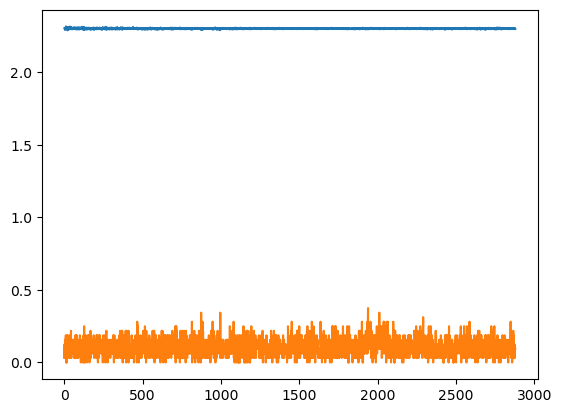

In [38]:
plt.plot(losses)
plt.plot(accs)